[View in Colaboratory](https://colab.research.google.com/github/lucksika/find_jennie/blob/master/blackpink_recognition.ipynb)

**BLACKPINK'S MEMBERS FACE RECOGNITION**

using face location from github: ageitgey / face_recognition <br>
using face recognition from github: krasserm / face-recognition <br>


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
!apt update
!apt install -y cmake
!pip install dlib

In [0]:
!pip install pydrive

In [0]:
!pip install face_recognition

In [0]:
import dlib
import numpy as np
import os.path
import tensorflow as tf

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

model = drive.CreateFile({'id':'1Go_LF5iqB-N0N9kqXPG-IFoOo4aisDtB'})
utils = drive.CreateFile({'id':'1XKdUzTxW_63vUBxE1FrRYzwbuK6p5HeC'})
data = drive.CreateFile({'id':'1ZhcwOudrc4uM_65vSaW0Mf6qu8a_UQOI'})
align = drive.CreateFile({'id':'1QRei90vURupyX38gE_nG1Lnc7oSzRkjx'})


In [0]:
model.GetContentFile('model.py')
utils.GetContentFile('utils.py')
data.GetContentFile('data.py')
align.GetContentFile('align.py')


In [0]:
import model
import utils
import data
import align
import face_recognition


In [0]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('drive/My Drive/deep_learning_proj/face_recognition/dataset_big')

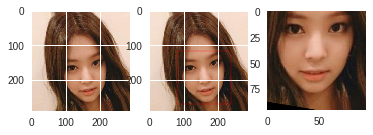

In [0]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from align import AlignDlib

%matplotlib inline

img_idx = random.randrange(400)


def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('drive/My Drive/deep_learning_proj/face_recognition/models/landmarks.dat')


###### find jennie face ########
#jn_path = 'drive/My Drive/deep_learning_proj/face_recognition/jennie/find_jennie_face.jpg'
# Load an image of JENNIE
#jn_orig = load_image(jn_path)

#### Random face from metadata ####
rand_orig = load_image(metadata[img_idx].image_path())

orig = rand_orig

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(orig)

# Transform image using specified face landmark indices and crop image to 96x96
rand_aligned = alignment.align(96, orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.grid(False)
plt.imshow(rand_aligned);

**========================== CODE FOR TRAIN MODEL FOR FINDING EMBEDDING =================================**

In [0]:
from model import create_model

nn4_small2 = create_model()

In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [0]:
#### TRAIN MODEL #####


from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)


# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data. I'll maybe provide a fully functional generator
# later.

**====================================================**

In [0]:
nn4_small2_pretrained = model.create_model()
nn4_small2_pretrained.load_weights('drive/My Drive/deep_learning_proj/face_recognition/weights/nn4.small2.v1.h5')

In [0]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
#OUTER_EYES_AND_NOSE

In [0]:
_embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    if img is None:
      continue
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    if i % 50 == 0:
      print(f'embedded image {i+1} / {metadata.shape[0]}' )
    _embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

    

embedded image 1 / 479
embedded image 51 / 479
embedded image 101 / 479
embedded image 151 / 479
embedded image 201 / 479
embedded image 301 / 479
embedded image 351 / 479
embedded image 401 / 479
embedded image 451 / 479


In [0]:
print(_embedded.shape)
print(metadata.shape)

(479, 128)
(479,)


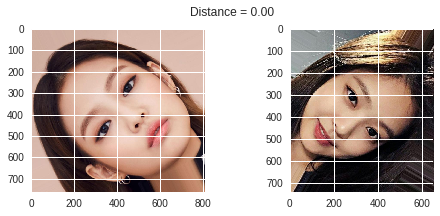

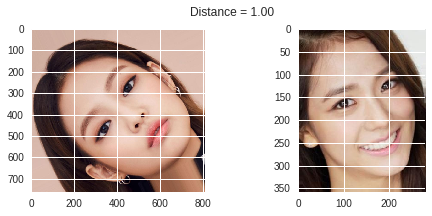

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(_embedded[idx1], _embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

    
### Compare the distance of the embbeding betwee same person and other person #####
show_pair(370, 420)
show_pair(370, 310)

In [0]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [0]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx, test_idx = train_test_split(np.arange(metadata.shape[0]), test_size=0.4, random_state=42)

embedded = _embedded.copy()

X_train = embedded[train_idx]
X_test = embedded[test_idx]
print(X_train.shape)
print(X_test.shape)

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()
rf = RandomForestClassifier(n_jobs=-1)

%time knn.fit(X_train, y_train)
%time svc.fit(X_train, y_train)
%time rf.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
acc_rf = accuracy_score(y_test, rf.predict(X_test))

#print(f'KNN accuracy = {acc_knn}')
print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}, RF accuracy = {acc_rf}')

(287, 128)
(192, 128)
CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.53 ms
CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 15.3 ms
CPU times: user 30.2 ms, sys: 2.41 ms, total: 32.6 ms
Wall time: 111 ms
KNN accuracy = 0.9479166666666666, SVM accuracy = 0.890625, RF accuracy = 0.8802083333333334


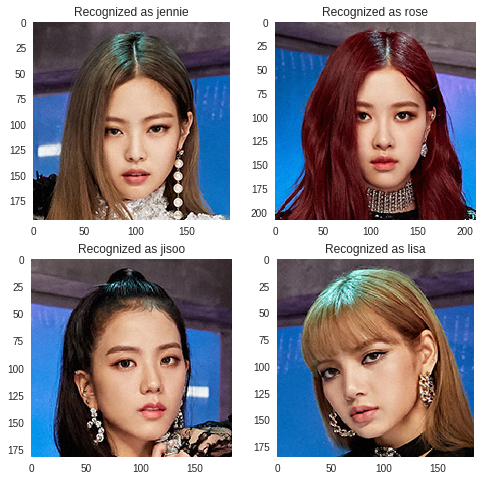

In [0]:
import warnings
warnings.filterwarnings('ignore')

jen_path = 'drive/My Drive/deep_learning_proj/face_recognition/test_image/d_jennie.jpg'
ros_path = 'drive/My Drive/deep_learning_proj/face_recognition/test_image/rose.jpg'
jisoo_path = 'drive/My Drive/deep_learning_proj/face_recognition/test_image/jisoo.jpg'
lisa_path = 'drive/My Drive/deep_learning_proj/face_recognition/test_image/lisa.jpg'

arr = [jen_path, ros_path, jisoo_path, lisa_path]
res = []

f, axs = plt.subplots(2,2,figsize=(8,8))
for i, a in enumerate(arr):
    _img = load_image(a)
    img = align_image(_img)
    if img is None:
      continue
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    pred = svc.predict([embedded])
    enc = encoder.inverse_transform(pred)[0]
    
    plt.subplot(221+i)
    plt.imshow(_img)
    plt.grid(False)
    plt.title(f'Recognized as {enc}');


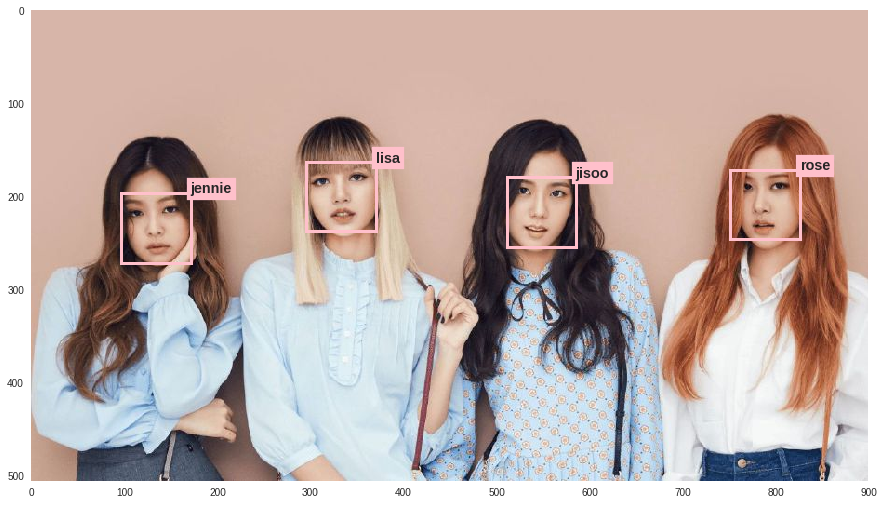

In [0]:
bp_test = load_image('drive/My Drive/deep_learning_proj/face_recognition/test_image/blackpink_7.jpg')

#### Locate all the faces in the image ######
boxes = face_recognition.face_locations(bp_test)
#print(boxes)
#top, right, bottom, left


#f, axs = plt.subplots(2,2,figsize=(8,8))
fig, ax = plt.subplots(1, figsize=(15,15))
ax.imshow(bp_test)
for i, c in enumerate(boxes):
  y = c[0]
  x = c[3]
  bottom = c[2]
  right = c[1]
  
  _y = c[0]-65
  _x = c[3]-50
  _bottom = c[2] + 50
  _right = c[1] + 50
  
  crop_img = bp_test[y: bottom, x: right]
  rect = patches.Rectangle((x,y),right - x,bottom - y,linewidth=3,edgecolor='pink',facecolor='none')
  ax.add_patch(rect)
  
  #close up face
  img = align_image(crop_img)
  img = (img / 255.).astype(np.float32)
  embedded = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
  pred = svc.predict([embedded])
  enc = encoder.inverse_transform(pred)[0]
  ax.text(right , y, enc, size='x-large', weight='bold', backgroundcolor='pink')
  #plt.subplot(221+i)
  #plt.imshow(img)
  
  #plt.imshow(crop_img)
plt.grid(False)
plt.show()

